## Binary classification with Logistic regression 

Question to answer: Can we predict if someone will default on their loan at the end of the contract?
<br/>
<br/>
Default meaning - someone will NOT pay back their loan - in the bank data this would be status 'B'.

Process:<br/><br/>
  **1. Getting Data**<br/>
      1.1 connection to database<br/>
      1.2 writing query<br/>
      1.3 creating df<br/><br/>
  **2. EDA**<br/>
      2.1 shape<br/>
      2.2 data types (correct type for model, same units?)<br/>
      2.3 null values, white spaces, duplicates, (amount)unique values per col /unique(written same), misslabled classes (male ≠ Male), typos/inconsistent capitalization, irrelevant columns<br/>
      2.4 missing data?<br/>
      2.5 num vs cat data (split)<br/>
      2.6 metrics (min/max difference features)<br/>
      2.7 distribution (normalizing?, scale x axis, outlier detection)<br/>
      2.8 multicollinearity<br/><br/>
  **3. Data cleaning/wrangling**<br/>
      3.1 apply what you detected in the EDA<br/>
      3.2 missing data - dropping or imputing (cat - new class, num - flag & fill)<br/>
      3.3 outlier removal<br/>
      3.4 creating new variables/feautres (using Regex to extract important new columns)
      3.4 always check if it worked!<br/><br/>
  **4. Pre processing**<br/>
      4.1 splitting data set into cat and num<br/>
      4.2 rescaling
      4.3 standardizing<br/>
      4.4 normalizing num data (MinMaxScaler, RobustScaler, StandardScaler, and Normalizer)<br/>
      4.5 encoding cat data (OHE or dummy veriables)<br/>
      4.6 merging num and cat. back together <br/>
      4.7 split off depended variable (y = Label) + drop from cat data<br/>
      4.5 merge processed num and cat in X<br/><br/>
  **5. Model run**<br/>
      5.1 import model<br/>
      5.2 do train test split<br/>
      5.3 run model<br/><br/>
      5.4 prediction<br/><br/>
  **6. Model evaluation/visualization**<br/>
      6.1 confusion matrix<br/>
      6.2 calculate metrics: accuracy, precision, recall<br/>
      6.3 ROC<br/>
      6.4 AUC<br/><br/>
  **7. Conclusion**<br/><br/>
  **8. Next steps - improvements**<br/>
      8.1 imbalance<br/>
      8.2 further pre processing <br/>
      8.3 feature selection

#### importing libraries

In [3]:
from sqlalchemy import create_engine
import pymysql
import getpass
password = getpass.getpass()

········


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Connection to database bank and getting data via query

In [5]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [6]:
df = pd.read_sql('''select t.type, t.operation, t.amount as t_amount, t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status from trans t
left join loan l
on t.account_id = l.account_id
where l.status in ('A', 'B')''', engine)

In [7]:
df.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A


#### EDA - exploratory data analysis 

In this part we want to get to know the data better.

check the shape/head/info/describe
check the data types (need to be changed?, are it the correct types for the model?)
check for nulls and white spaces (drop or replace)
check ditribution num and cat (histograms, boxplots)
check multicollinearity
split data into sum and cat


**check the shape/head/info/describe**

In [8]:
#get an idea of how much data we have
df.shape

#74.364 rows is good - large dataset we need for logistic

(74364, 9)

In [9]:
#I want to get a first overview of nulls, data types
df.info()

#looks like we dont have any null values, wuhu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  int64  
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 5.1+ MB


In [10]:
df.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [11]:
#I want to see the metrics of the columns like mean, count, min/max
df.describe()

,t_amount,balance,l_amount,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


**check the data types**

In [12]:
#Having a closer look at the data types
df.dtypes

#we have objects, floats and integers - so num and cat
#we could convert duration to object 

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration       int64
payments     float64
status        object
dtype: object

**num VS cat - splitting up**

How to get num and cat data<br/>

**numericals** = data._get_numeric_data()<br/>
OR<br/>
**numericals** = data.select_dtypes(np.number)<br/><br/>

**categoricals** = data.select_dtypes(np.object)

In [27]:
cat = df.select_dtypes(include = np.object)
num = df.select_dtypes(include=np.number)

In [22]:
#checking the categorical features in more detail

print('Categorical Features:', len(cat))
print('----------')
for c in cat:
    print('Name: {}'.format(df[c].name))    # column name
    print('Type: {}'.format(df[c].dtype))   # column type
    print('Unique values: {}'.format(len(df[c].unique())))   # column unique values
    print(df[c].unique())
    print(((df[c].value_counts()/ sum(df[c].value_counts()))*100))   # percentage
    print('\n----------')

Categorical Features: 74364
----------
Name: type
Type: object
Unique values: 3
['PRIJEM' 'VYDAJ' 'VYBER']
VYDAJ     59.269270
PRIJEM    37.195417
VYBER      3.535313
Name: type, dtype: float64

----------
Name: operation
Type: object
Unique values: 6
['PREVOD Z UCTU' 'VKLAD' '' 'VYBER' 'PREVOD NA UCET' 'VYBER KARTOU']
VYBER             46.617987
                  19.695014
PREVOD NA UCET    15.662148
VKLAD             14.153354
PREVOD Z UCTU      3.347050
VYBER KARTOU       0.524447
Name: operation, dtype: float64

----------
Name: k_symbol
Type: object
Unique values: 8
['' 'UROK' ' ' 'SIPO' 'SLUZBY' 'POJISTNE' 'UVER' 'SANKC. UROK']
               48.347319
UROK           19.695014
SLUZBY         15.203593
SIPO            6.832607
                4.058415
UVER            3.890323
POJISTNE        1.558550
SANKC. UROK     0.414179
Name: k_symbol, dtype: float64

----------
Name: status
Type: object
Unique values: 2
['A' 'B']
A    86.868646
B    13.131354
Name: status, dtype: float64

--

**check for nulls and white spaces**

nulls we already checked, they are fine, but we saw the white spaces in k_symbol

In [13]:
df['k_symbol'].value_counts()

#3018 blank cells - NOT GOOD need to be replaced with at least 'unknown'
#should not drop them, as they are too many

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [14]:
#check the other cat columns for the empty values
df['type'].value_counts()

#looks good

VYDAJ     44075
PRIJEM    27660
VYBER      2629
Name: type, dtype: int64

In [15]:
df['operation'].value_counts()
#does not not look good, should replace the empty ones

VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64

In [16]:
df['status'].value_counts()
#looks good, no changes needed

A    64599
B     9765
Name: status, dtype: int64

**check ditribution num and cat (histograms, boxplots)**

numerical data

In [17]:
#get an overview of all histograms
data_num = df.select_dtypes(include=['number'])

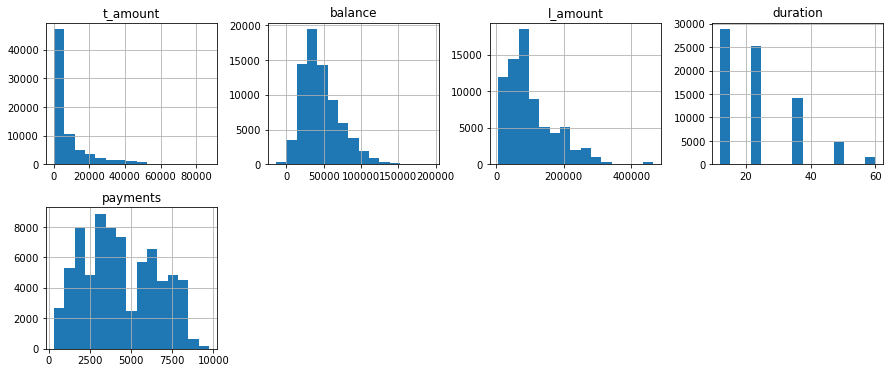

In [18]:
data_num.hist(bins=15, figsize=(15, 6), layout=(2, 4));

<function matplotlib.pyplot.show(close=None, block=None)>

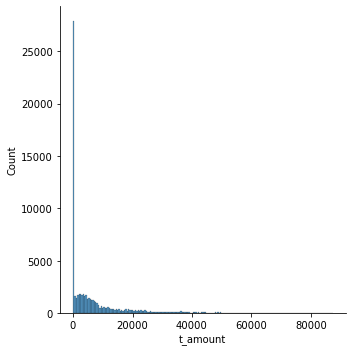

In [30]:
#Distributionplots (Histograms) - check the distributions

sns.displot(df['t_amount'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

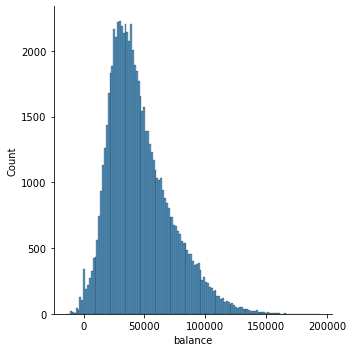

In [31]:
sns.displot(df['balance'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

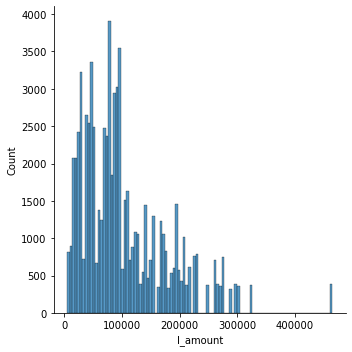

In [32]:
sns.displot(df['l_amount'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

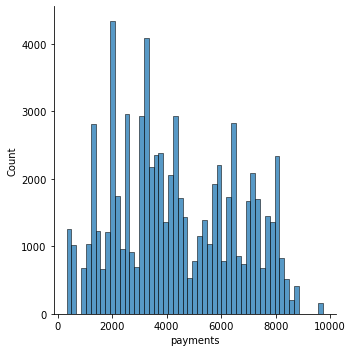

In [33]:
sns.displot(df['payments'])
plt.show

we can see that the values are very much far away in the max values
this is why we are going to normalize them


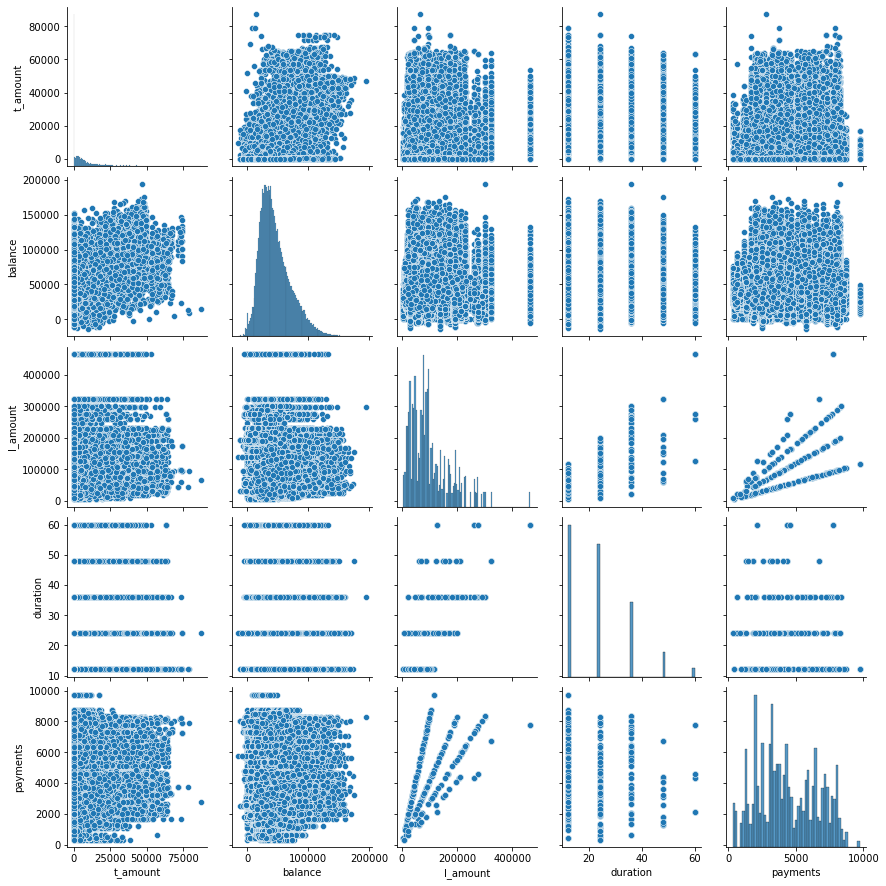

In [28]:
#check normality visually
sns.pairplot(num)

categorical data

Frequency analysis of column:  type
Frequency analysis of column:  operation
Frequency analysis of column:  k_symbol
Frequency analysis of column:  status


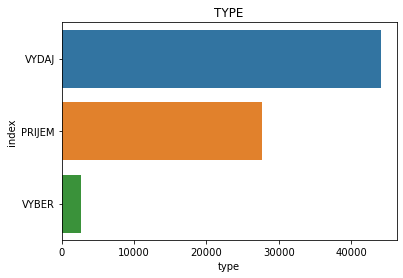

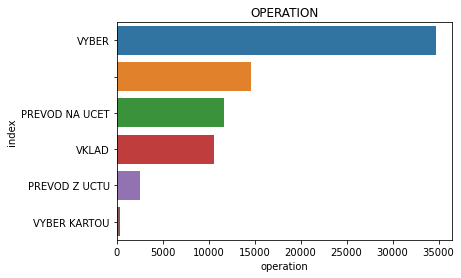

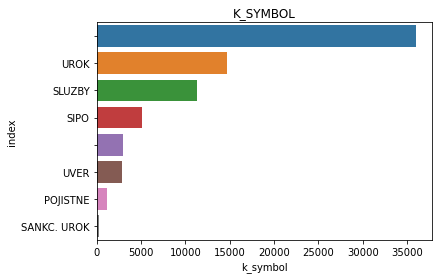

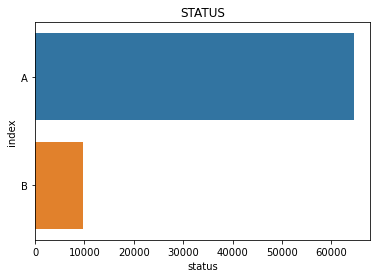

<Figure size 432x288 with 0 Axes>

In [19]:
#view of all frequency analysis of all cat columns
cols_cat = list(df.select_dtypes(include=['object']).columns)

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = df[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print

#we have a big set of A and a small set of B - little bit unbalanced


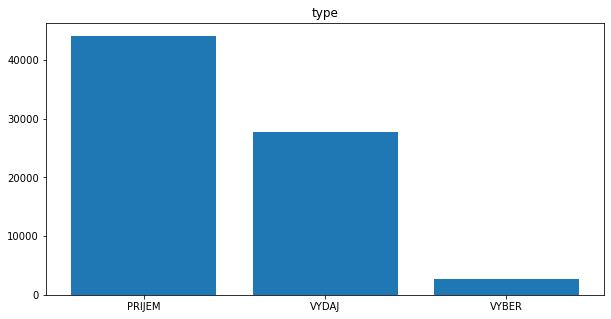

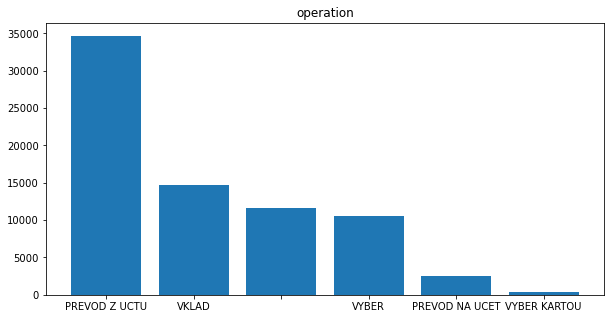

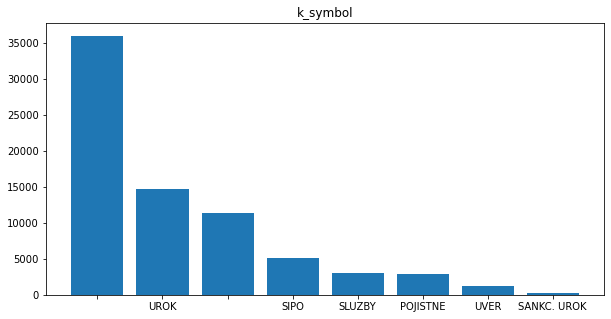

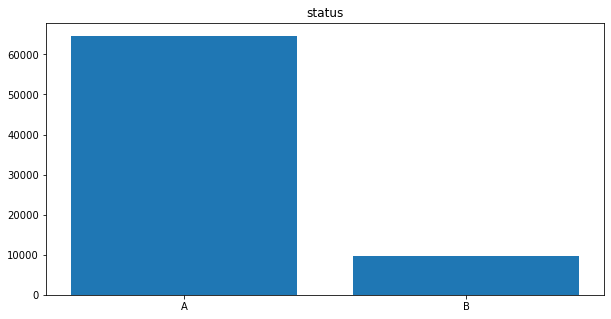

In [25]:
#or use this one 
for c in cat:
    plt.figure(figsize=(10,5))
    plt.bar(df[c].unique(), df[c].value_counts())
    plt.title(c)
    plt.show();

**check multicollinearity (mc)**

The higher the number, the higher the mc (everything 0.3-0.4 and then 1 above 0.75 1 of the col should be dropped).



In [35]:
df.corr()

#shows only the numerical data

,t_amount,balance,l_amount,duration,payments
t_amount,1.000000,0.426564,0.051994,-0.005911,0.078869
balance,0.426564,1.000000,0.022099,-0.032321,0.066544
l_amount,0.051994,0.022099,1.000000,0.653746,0.633249
duration,-0.005911,-0.032321,0.653746,1.000000,-0.058222
payments,0.078869,0.066544,0.633249,-0.058222,1.000000


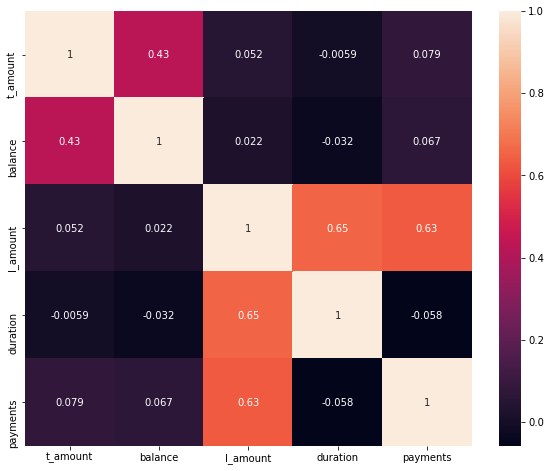

In [36]:
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#amount and payment - the higher amount, the higher needs to be the payment - ok, expected corr
#amount and duration - the bigger the loan the longer time needed to pay back - ok, expected corr
#no need to do smt from this

#### Cleaning Steps
- change duration to an object type/categorical (12,24,36,48,72)
(as we dont want to add the numbers, we can change it to cat.Not on size of duratio but on bucket of people with that duration)
- ksymbol -> replace white spaces with unknown
- operations -> replace white spaces with unknown

change duration to an object type/categorical (12,24,36,48,72)

In [37]:
df['duration']=df['duration'].astype('str')
df['duration']=df['duration'].astype('object')

In [38]:
#checking what we done worked?
df.dtypes

#change duration from in to object worked!

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration      object
payments     float64
status        object
dtype: object

ksymbol -> replace white spaces with unknown

In [39]:
#writing a function to replace the empty strings ('') & white spaces (' ')
def cleankSymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [40]:
#applying the function on the col
df['k_symbol'] = df['k_symbol'].apply(cleankSymbol)

In [41]:
#checking if it worked
df['k_symbol'].value_counts()

#yes, it worked, wuhu

unknown        38971
UROK           14646
SLUZBY         11306
SIPO            5081
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

operations -> replace white spaces with unknown

In [42]:
df['operation'].unique()
#here we see that we want to get rid of ''

array(['PREVOD Z UCTU', 'VKLAD', '', 'VYBER', 'PREVOD NA UCET',
       'VYBER KARTOU'], dtype=object)

In [43]:
#writing a function to replace the empty strings ('')
def cleankOperations(x):
    if x in ['']:
        return 'unknown'
    else:
        return x

In [44]:
df['operation'] = df['operation'].apply(cleankOperations)

In [45]:
#checking if it worked
df['operation'].value_counts()

#yes, it worked, wuhu

VYBER             34667
unknown           14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64

### Pre Processing

- splitting data set into cat and num
- normalizing num data
- booleaning the cat data
- Split off depended variable (Label)
- merge num and cat in X

**splitting data set into cat and num**

In [46]:
cat = df.select_dtypes(include = np.object)
cat

#has 5 colums

,type,operation,k_symbol,duration,status
0,PRIJEM,PREVOD Z UCTU,unknown,24,A
1,PRIJEM,VKLAD,unknown,12,A
2,PRIJEM,VKLAD,unknown,36,A
3,PRIJEM,VKLAD,unknown,12,A
4,PRIJEM,VKLAD,unknown,12,A
...,...,...,...,...,...
74359,PRIJEM,unknown,UROK,36,A
74360,PRIJEM,unknown,UROK,24,B
74361,PRIJEM,unknown,UROK,36,A
74362,PRIJEM,unknown,UROK,60,A


**booleaning the cat data**

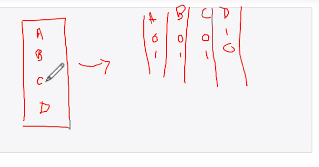

In [47]:
#only on categorical data NOT num
#pd.get_dummies

#replace values with an arry (0,1)
categorical = pd.get_dummies(cat, columns =['type', 'operation', 'k_symbol', 'status'], drop_first=True)
categorical

#(drop_first=True) makes us less columns, if all other are 0 then its the first we. dropped
#e.g. status - now only B shown not A, everything where B = 0, A should be 1
#if we dont drop it, multicollinearity will happen

#splits the column into all the possible values in the column in a new column and checks if the value is in there
#e.g. colum type_VYBER? yes - 1, no -0

,duration,type_VYBER,type_VYDAJ,operation_PREVOD Z UCTU,operation_VKLAD,operation_VYBER,operation_VYBER KARTOU,operation_unknown,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_UVER,k_symbol_unknown,status_B
0,24,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,12,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,36,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,12,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,12,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74359,36,0,0,0,0,0,0,1,0,0,0,1,0,0,0
74360,24,0,0,0,0,0,0,1,0,0,0,1,0,0,1
74361,36,0,0,0,0,0,0,1,0,0,0,1,0,0,0
74362,60,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [48]:
categorical['status_B'].value_counts()

#0 - not B
#1 - B

0    64599
1     9765
Name: status_B, dtype: int64

**normalizing num data**
 <br/> <br/>
**Scale** generally means to change the range of the values. The shape of the distribution doesn’t change. Think about how a scale model of a building has the same proportions as the original, just smaller. That’s why we say it is drawn to scale. The range is often set at 0 to 1. <br/>
**Standardize** generally means changing the values so that the distribution standard deviation from the mean equals one. It outputs something very close to a normal distribution. Scaling is often implied. <br/>
**Normalize** can be used to mean either of the above things (and more!). I suggest you avoid the term normalize, because it has many definitions and is prone to creating confusion.

In [49]:
from sklearn.preprocessing import Normalizer

In [50]:
num = df.select_dtypes(include=np.number)

In [51]:
transformer = Normalizer().fit(X)
num_normalised = transformer.transform(X)
num_normalised = pd.DataFrame(num_normalised)

NameError: name 'X' is not defined

In [ ]:
num_normalised
#it worked, juhu

In [ ]:
num_normalised.columns

In [ ]:
#re run histograms to see if it changed something
sns.displot(num_normalised[0])
plt.show

In [ ]:
sns.displot(num_normalised[1])
plt.show

In [ ]:
sns.displot(num_normalised[2])
plt.show

We can see that now the num values are all in the range of 0-1 which makes it better to compare!
Great!

**Split off depended variable (Label)**

status_B because we want to know if they are bad or not

In [ ]:
y = categorical['status_B']

#split of status_b from the other cat
categorical = categorical.drop(['status_B'],axis=1)
categorical

**Merge num (scaled) and cat (boolean - status B) together in X**

In [ ]:
#checking if both df have the same lenght befor concating
len(num_normalised), len(categorical)

#looks good, its the same!

In [ ]:
X = np.concatenate((num_normalised, categorical), axis=1)
X

### Model Run

- import model
- Train Test Split
- apply model

**import model**

In [ ]:
from sklearn.linear_model import LogisticRegression

**Train Test Split**

splitting X and y each into 2 data sets(train data and test data) 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test,  y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=40)

**Model Development**
- create a Logistic Regression classifier (classification) object using LogisticRegression() function
- fit model on the train set using fit()

In [ ]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter = 400, multi_class='ovr').fit(X_train,y_train)

**Prediction**
- perform prediction on the test set using predict()

In [ ]:
predictions = classification.predict(X_test)

In [ ]:
predictions

### Model Evaluation using Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Building Confusion Matrix

In [ ]:
cnf_matrix = confusion_matrix(y_test, predictions)
cnf_matrix

Visualizing Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

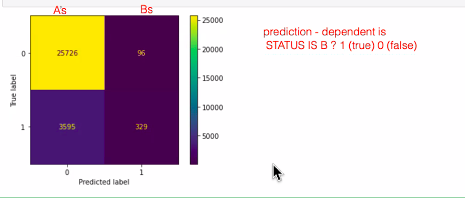

**Look which is the dependend variable (here its B)** <br/>
A = 0 - false - does not default<br/>
B = 1 - true - defaults<br/>

**Explanations**<br/>
TN(True negative,0/0) - we think its A and it is A<br/>
FN(False negative,1/0) - we think its A but its B<br/>
FP(False positive,0/1) - we think its B, but its A<br/>
TP(True positive,1/1) - we think its B and it is B<br/><br/>
Three true negative predictions: The first three observations are zeros predicted correctly.<br/>
No false negative predictions: These are the ones wrongly predicted as zeros.<br/>
One false positive prediction: The fourth observation is a zero that was wrongly predicted as one.<br/>
Six true positive predictions: The last six observations are ones predicted correctly.<br/>

**What does which number say**<br/>
TP & TN should be high<br/>
FN & FP should be low<br/>

**Errors**<br/>
FP (type 1 error)<br/>
FN (type 2 error)<br/>

**Conclusion**<br/>
FP - Its ok.<br/>
FN - Its bad that there are so many false As
becasue we think the loan will not default, but instead it does.<br/>

**BE AWARE OF OVERFITTING**<br/>
- accuracy is over 90<br/>
- when high accuracy in trianing, and low accuracy in testing<br/>
- solution: good spread in train and test

**Metrics (accuracy, precision, recall)**

In [ ]:
from sklearn.metrics import accuracy_score

Classification rate of 87% -> considered as good accuracy

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, predictions))


**Precision:** Precision is about how accurate your model is.
When a model makes a prediction, how often it is correct.

Here: when Logistic Regression model predicted if customer is going to suffer default, that client will default 71% of the time.

In [ ]:
print("Precision:",metrics.precision_score(y_test, predictions))

**Recall:** If there are clients who will default in the test set, our Logistic Regression model can identify it 8% of the time.

-> this seems a little low 

In [ ]:
print("Recall:",metrics.recall_score(y_test, predictions))

### Visualizing accuracy - ROC/AUC

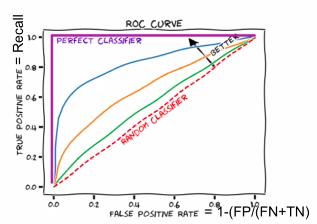

**ROC Curve**
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- the closer to left hand corner the better
- should not be below red line

**!After each iteration of imporvements your line should get closer to the left**

tpr = true positive rate -> you are told you are pregnant and you really are<br/>
fpr = false positive rate -> positive answer is yes, but in reality its no / being told that you are pregnant, but you are not<br/>
fn = false negative -> you are told you are not pregnant but you really are

In [ ]:
y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**AUC** - area under the curve
the bigger the area under the curve the better the model<br/>
1 represents perfect classifier, and 0.5 represents a worthless classifier.

**AUC = 0.77** - semi ok

In [ ]:
#anything better then guess work is better then nothing

### Next Steps - Improvements

**What to improve and ideas how to:**

**What:** improve the 3595 values in FN

**Ideas**
- we could use more data
- its becasue the data is very imbalanced on status (we dont have many Bs, but many As)

<br/>

**Other things we could do to improve:**
- imbalance check
- go back to pre processing 
- feature selection